In [25]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

# Caclulate $\mu_{max}$ from experimental growth curve

In [26]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [27]:
df = pd.read_excel('../experimental-data/Biomass CscB-SPS original strain.xlsx',sheet_name='Compiled')
df.head()

,Time,OD750,IPTG,Biomass,Sucrose,Total Biomass,% Sucrose,% Biomass,Biomass Ratio
0,0,0.271,0.0,0.075790,0.020914,0.096704,0.216271,0.783729,0.275951
1,0,0.300,0.0,0.090530,0.031371,0.121901,0.257351,0.742649,0.346531
2,0,0.270,0.0,0.077890,0.027108,0.104998,0.258176,0.741824,0.348029
3,6,0.440,0.0,0.130530,0.028273,0.158803,0.178038,0.821962,0.216602
4,6,0.396,0.0,0.136842,0.027111,0.163953,0.165359,0.834641,0.198120


In [28]:
df2 = df.loc[df.IPTG==0]
popt, pcov = curve_fit(mu_func,df2.Time, df2.OD750)

In [29]:
popt[1]/3600

1.889387235661103e-05

In [30]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893

# Smooth OD750 data for fitting
#test_data.loc[:,'OD750'] = od_func(test_data.IPTG)
#popt, pcov = curve_fit(suc_func, test_data.IPTG, test_data.Sucrose)
    #Compare output with experimental data
#OD = interpolate.interp1d(test_data.IPTG,test_data.OD750)
#Sucrose = interpolate.interp1d(test_data.IPTG,test_data.Sucrose)
#sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
x_range = np.arange(0,1,.01)
#plt.plot(x_range,suc_func(x_range))
#plt.plot(test_data.IPTG,test_data.Sucrose,marker='o')
#plt.plot(x_range, suc_func(x_range, *popt), 'r-')
#xr = np.array([0.001,.01,.05,0.2,1])
#

#residual = abs(r2_score(exp(x_range),sim(x_range))-1)
#  r4 = r1 * ${alpha} * suc_exp / (${kappa} + suc_exp); 
#  r5 = ${beta} * r1 * (suc_exp / (${kappa_2} + suc_exp) + ${delta}); 

In [31]:
mu = .06/3600
def od_fit(x,a,b,c):
    return 1-a*np.exp(-x/b)-c
popt, pcov = curve_fit(od_fit, test_data.IPTG, test_data.OD750/od_func(0))
popt

array([-0.18415048,  0.06811174,  0.18415069])

In [32]:
mu

1.6666666666666667e-05

In [33]:
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
popt2, pcov2 = curve_fit(suc_func, test_data.IPTG, test_data.Sucrose)
popt2

array([-3.26601079,  0.03910353,  3.24273204])

In [34]:
def suc2(x,a,b,c):
    return a*x/(x+b)+c
popt3, pcov3 = curve_fit(suc2, test_data.IPTG, test_data.Sucrose)

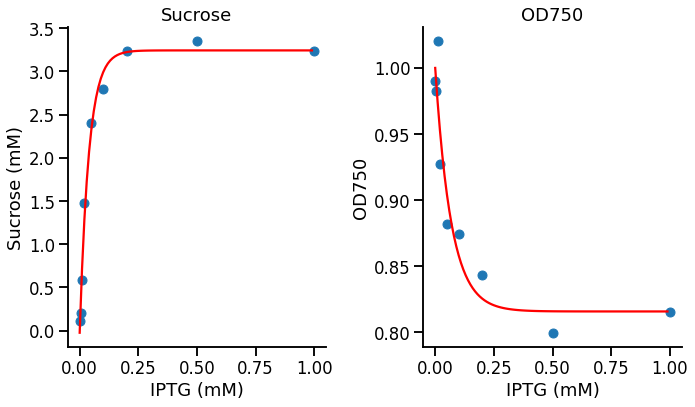

In [35]:
import seaborn as sns
sns.set_context('talk')
f, ax = plt.subplots(ncols=2,figsize=(10,6))
#ax[1].plot(x_range,od_func(x_range))

ax[0].set_title('Sucrose')
ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o',ls='')
ax[0].plot(x_range,suc_func(x_range, *popt2), 'r-')
ax[0].set_xlabel('IPTG (mM)')
ax[1].set_xlabel('IPTG (mM)')
ax[0].set_ylabel('Sucrose (mM)')
ax[1].set_ylabel('OD750')
#ax[0].plot(x_range,suc2(x_range, *popt3),marker='d',ls='',c='r')
#ax[0].plot(df.IPTG,df.Sucrose)
ax[1].set_title('OD750')
ax[1].plot(test_data.IPTG,test_data.OD750/od_func(0),marker='o',ls='')
ax[1].plot(x_range, od_fit(x_range, *popt), 'r-')
#ax[1].plot(x_range,od_func(x_range)/od_func(0))
f.tight_layout()
sns.despine()
#ax[1].plot(df.IPTG,df.OD750)

In [36]:
t2 = test_data.copy()
t2.loc[2,'OD750']=1.40
t2.loc[4,'OD750']=1.23
t2.sort_values(by='IPTG',inplace=True)
print(t2)
abs(r2_score(t2[['OD750','Sucrose']],test_data[['OD750','Sucrose']])-1)

    IPTG     OD750   Sucrose
0  0.000  1.370000  0.107117
1  0.005  1.360000  0.200273
2  0.010  1.400000  0.584090
3  0.020  1.283333  1.473699
4  0.050  1.230000  2.405350
5  0.100  1.210000  2.790814
6  0.200  1.166667  3.234595
7  0.500  1.106667  3.348596
8  1.000  1.128333  3.230569


0.0012505885122411353